# Tests on Different Partitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import tqdm
from datetime import datetime, date, time
from scripts.estimation import *
from scripts.utils import *
from scripts.discovery import *
from scripts.seattle_data import *
import geopy.distance
import geopandas as gpd
import geojson
from shapely import wkt
from shapely.geometry import Point
import os
import json
import time
import pickle

## 1. Data Preprocessing

In [2]:
# Split train, validation, test data
np.random.seed(2)
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x}) 
df = pd.read_csv('bikesharing_seattle_data_july.csv')
df_august_formatted = pd.read_csv('bikesharing_seattle_data_august.csv')
df = df.drop(df.columns[0],axis=1)
df = pd.concat([df, df_august_formatted], ignore_index=True)

df['lat'] = df['lat'].astype('float64')
df['lng'] = df['lng'].astype('float64')
lat = df['lat']
lng = df['lng']
lat_min = 47.58
lat_max = 47.64
lng_min = -122.37
lng_max = -122.28
grid_size = 20
loc_bound = [lng_min,lng_max,lat_min,lat_max] # Set a bound for our interested region
time_interval = [15,15.5] # 8:00-8:30 local time in the morning
thres = 1 # Set a threshold for active bikes inside the downtown area
df_1 = df.copy()[['bike_id']]
df_1.loc[:,'inlatlng'] = np.array((df['lat']>lat_min) & (df['lat']<lat_max)) & (df['lng']>lng_min) & (df['lng']<lng_max) \
    & (df['state']!='available')
df_1.loc[:,'inran'] = np.array((df['lat']>lat_min) & (df['lat']<lat_max) & (df['lng']>lng_min) & (df['lng']<lng_max) \
    & (df['state']!='available')) & np.array([is_time_in_range(df['time'][i][11:],time_interval[0],time_interval[1]) for i in range(len(df))])
grouped = df_1.groupby(by='bike_id').sum()
avail_bikes = grouped[grouped['inran'] >= thres].index
df = df[df_1['inlatlng']]
df = df[df['bike_id'].isin(avail_bikes)].reset_index(drop=True)

In [3]:
df = df[df['state']!='available']
df,_ = process_bike_data(df)
df = filter_bikes_in_region(df, loc_bound[0], loc_bound[1], loc_bound[2], loc_bound[3])
df,df_init = process_bike_data(df,enforce_seq=False)
df = reset_bike_index(df)
train_period = 24
val_period = 7
test_period = 15
df_train = df[df['time']<'2019-07-25'].reset_index(drop=True).sort_values(by='bike_id', ascending=True, inplace=False)
df_validation = df[(df['time']>='2019-07-25')&(df['time']<'2019-08-01')].reset_index(drop=True).sort_values(by='bike_id', ascending=True, inplace=False)
df_test = df[(df['time']>='2019-08-01')&(df['time']<'2019-08-16')].reset_index(drop=True).sort_values(by='bike_id', ascending=True, inplace=False)
_,df_test_init = process_bike_data(df_test,enforce_seq=False)
df_test = reset_bike_index(df_test)
_,df_train_init = process_bike_data(df_train,enforce_seq=False)
df_train = reset_bike_index(df_train)
_,df_validation_init = process_bike_data(df_validation,enforce_seq=False)
df_validation = reset_bike_index(df_validation)


In [4]:
# Split the train data, run for allin algorithm/mixed-effects model

train_period = 31
df_train = df[df['time']<'2019-08-01'].reset_index(drop=True).sort_values(by='bike_id', ascending=True, inplace=False)
_,df_train_init = process_bike_data(df_train,enforce_seq=False)
df_train = reset_bike_index(df_train)

In [5]:
# Create the bike_loc array
lng0 = np.array(df_train_init['lng'])
lat0 = np.array(df_train_init['lat'])
bike_loc,all_period,book_time,book_finish_time,book_index,book_bike = create_bike_loc(df_train, lng0, lat0,total_day=train_period,initial_time = np.datetime64('2019-07-01 00:00:00'))
bike_loc,book_time,book_finish_time,book_index,book_bike, \
    all_period = extract_period_data(bike_loc,all_period,book_time,book_finish_time,book_index,book_bike,train_period,time_interval=time_interval)
    
bike_num = bike_loc.shape[1]
num_records = bike_loc.shape[0]
num_booked = len(book_time)
print(num_booked,num_records)

grid_size = 20
loc_bound = [lng_min,lng_max,lat_min,lat_max]

T_train = train_period*3600*(time_interval[1]-time_interval[0])
lng_mean = (-lng_min+lng_max)/2
lat_mean = (-lat_min+lat_max)/2
loc_bound2 = [-lng_mean,lng_mean,-lat_mean,lat_mean]

gdf = gpd.read_file("sea_loc_data/census_2020.geojson")
num_block = gdf.shape[0]
polygon_sets = []
for i in range(num_block):
    polygon_sets.append(gdf['geometry'][i])
    
# Only reserve blocks with at least one booking
gdf = gdf.iloc[np.unique(find_bike_index(bike_loc,polygon_sets,num_block).flatten())]
gdf = gdf.reset_index()
num_block = gdf.shape[0]
polygon_sets = []
for i in range(num_block):
    polygon_sets.append(gdf['geometry'][i])
    
Y = np.zeros((num_block,train_period),dtype=int)
gdf['book_num_train'] = np.zeros(num_block)        

for i in range(df_train.shape[0]):
    # check whether the booking is in the time interval
    time_str = df_train['time'][i][11:]
    if (df_train['state'][i]=='rent_start') and is_time_in_range(time_str, time_interval[0], time_interval[1]):
        lng = df_train['lng'][i]
        lat = df_train['lat'][i]
        for j in range(num_block):
            if polygon_sets[j].contains(Point(lng,lat)):
                gdf['book_num_train'][j] = gdf['book_num_train'][j]+1
                day = int(df_train['time'][i][8:10])
                Y[j,day-1] += 1
                break

gdf['book_num_test'] = np.zeros(num_block)  
df_bike = df_test.copy()

for i in range(df_bike.shape[0]):
    time_str = df_test['time'][i][11:]
    if (df_bike['state'][i]=='rent_start') and is_time_in_range(time_str, time_interval[0], time_interval[1]):
        lng = df_bike['lng'][i]
        lat = df_bike['lat'][i]
        for j in range(num_block):
            if gdf['geometry'][j].contains(Point(lng,lat)):
                gdf['book_num_test'][j] = gdf['book_num_test'][j]+1
                break
                
gdf_census = gpd.read_file("sea_loc_data/2020_census_tracts_seattle.geojson")
gdf_census['BASENAME'] = gdf_census['BASENAME'].astype(float)
gdf['TRACT_20_LABEL'] = gdf['TRACT_20_LABEL'].astype(float)
geometry_mapping = gdf_census.set_index('BASENAME')['geometry'].to_dict()
gdf['geometry'] = gdf['TRACT_20_LABEL'].map(geometry_mapping)

187066 (187065,) (187066,)


187074it [17:55, 173.86it/s]


2632 5341


100%|██████████| 5341/5341 [00:49<00:00, 107.93it/s]
/tmp/ipykernel_2981298/2831804894.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['book_num_train'][j] = gdf['book_num_train'][j]+1
/tmp/ipykernel_2981298/2831804894.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['book_num_test'][j] = gdf['book_num_test'][j]+1


In [6]:
cur_dist = 0
lng0 = np.array(df_test_init['lng'])
lat0 = np.array(df_test_init['lat'])
bike_loc_test,all_period_test,book_time_test,book_finish_time_test,book_index_test, \
    book_bike_test = create_bike_loc(df_test, lng0, lat0,total_day=test_period,initial_time = np.datetime64('2019-08-01 00:00:00'))
bike_loc_test,book_time_test,book_finish_time_test,book_index_test,book_bike_test, \
    all_period_test = extract_period_data(bike_loc_test,all_period_test,book_time_test,book_finish_time_test,book_index_test,book_bike_test,test_period,time_interval=time_interval) 
num_records_test = bike_loc_test.shape[0]
num_booked_test = book_index_test.shape[0]
book_num_test = num_booked_test
T_test = 3600*(time_interval[1]-time_interval[0])*test_period
bike_num_test = bike_loc_test.shape[1]


94744 (94743,) (94744,)


94752it [03:03, 517.63it/s]


## 2. Prediction of bookings on 100 partitions

The service region is divided into small identical rectangular blocks. We generate 100 different partitions with different lengths, widths and locational shifts, ranging from 110 to 213 total number of blocks, which are stored in `sea_loc_data/sea_poly_list.pkl`. We index the $100$ rectangular partitions from $0$ to $99$ and train 10 different mixed-effects model each using a different partition $k\in\{0,10,\cdots,90\}$. We then predict the number of bookings in each block for each partition under each algorithm. Results are saved under folder `sea_pred_results`.

In [7]:
# Load the 100 partitions
with open('sea_loc_data/sea_poly_list.pkl', 'rb') as file:
    sea_poly_list = pickle.load(file)

/tmp/ipykernel_2981298/4261984342.py:3: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  sea_poly_list = pickle.load(file)


In [ ]:
baseline_mode = True # True if we want to predict bookings for mixed-effects models
all_in_mode = False # True if we want to predict bookings for the all-in algorithm
disc_mode = False # True if we want to predict bookings for the discovery algorithm

with open('sea_pred_results/allin_prediction_8-830.pkl', 'rb') as file:
    pre_loc_allin = pickle.load(file)
    pre_w_allin = pickle.load(file)

with open('sea_pred_results/disc_estbeta_8-830.json', 'r') as file:
    loc_disc_data = json.load(file)
    
disc_batch_w = np.array(loc_disc_data['disc_batch_w'])
disc_batch_loc = np.array(loc_disc_data['disc_batch_loc'])

for model_index in tqdm(np.arange(0,100,10)):
    train_division = sea_poly_list[model_index]
    with open(f'sea_pred_results/mixed_effect_pred_params/mixed_effects_prediction_{model_index}.pkl', 'rb') as file:
        pre_loc_baseline = pickle.load(file)
        pre_w_baseline = pickle.load(file)
        pred_params = pickle.load(file)
        beta1_min = pickle.load(file)
        result_min = pickle.load(file)
        pred_w = pickle.load(file)

    if baseline_mode:
        pre_w = pre_w_baseline
        pre_loc = pre_loc_baseline
        beta1_cur = beta1_min
    elif all_in_mode:
        pre_w = pre_w_allin
        pre_loc = pre_loc_allin
        beta1_cur = -4.0
    elif disc_mode:
        pre_w = disc_batch_w
        pre_loc = disc_batch_loc
        beta1_cur = -4.4

    beta0 = 1
    loc_old = pre_loc
    bike_num = bike_loc.shape[1]
    p_old = np.zeros((pre_w.shape[0],bike_num+1,num_records))
    p_olds = np.zeros((pre_w.shape[0],num_booked))
    f_old = np.zeros((pre_w.shape[0],num_records))
    w_old = pre_w
    beta1 = beta1_cur
    loc_old = pre_loc

    cur_dist = caldist_geo(loc_old,bike_loc)
    s = np.sum((1-np.sum(np.expand_dims(pre_w,1)*(1/(1+np.sum(np.exp(beta0+beta1*cur_dist),axis=2))),axis=0))*all_period)
    lambd = num_booked*T_train/s
    if baseline_mode:
        lambd = np.sum(pred_w)*train_period

    num_div = 100
    avg_train_WMAPE = 0
    avg_test_WMAPE = 0

    train_WMAPE_rec = np.array([])
    test_WMAPE_rec = np.array([])

    for div_index in tqdm(range(num_div)):
        polygon_sets = sea_poly_list[div_index]
        num_block = len(sea_poly_list[div_index])
        num_block_train = len(result_min.random_effects)
        block_area_train = np.array([train_division[i].area for i in range(1,num_block_train)])
        overlap_area = np.zeros((num_block,num_block_train)) # Overlap area between blocks in the testing and training partitions
        random_effects = np.array([result_min.random_effects[i+1] for i in range(1,num_block_train)]).flatten()
        for i in range(num_block):
            for j in range(1,num_block_train):
                overlap_area[i,j] =  polygon_sets[i].intersection(train_division[j]).area

        random_effect_block = np.zeros(num_block)
        for i in range(num_block):
            random_effect_block[i] = np.sum(overlap_area[i,1:]*random_effects/block_area_train)

        gdf_sea_poly = gpd.GeoDataFrame(geometry=polygon_sets)

        # Train
        gdf_sea_poly['book_num_train'] = np.zeros(num_block)  
        df_bike = df_train.copy()

        for i in range(df_bike.shape[0]):
            time_str = df_train['time'][i][11:]
            if (df_bike['state'][i]=='rent_start') and is_time_in_range(time_str, time_interval[0], time_interval[1]):
                lng = df_bike['lng'][i]
                lat = df_bike['lat'][i]
                for j in range(num_block):
                    if polygon_sets[j].contains(Point(lng,lat)):
                        gdf_sea_poly['book_num_train'][j] = gdf_sea_poly['book_num_train'][j]+1
                        break

        # Test
        gdf_sea_poly['book_num_test'] = np.zeros(num_block)  
        df_bike = df_test.copy()

        for i in range(df_bike.shape[0]):
            time_str = df_test['time'][i][11:]
            if (df_bike['state'][i]=='rent_start') and is_time_in_range(time_str, time_interval[0], time_interval[1]):
                lng = df_bike['lng'][i]
                lat = df_bike['lat'][i]
                for j in range(num_block):
                    if polygon_sets[j].contains(Point(lng,lat)):
                        gdf_sea_poly['book_num_test'][j] = gdf_sea_poly['book_num_test'][j]+1
                        break


        # Train
        dist_train = caldist_geo(loc_old,bike_loc)
        bike_poly_index = find_bike_index(bike_loc,polygon_sets,num_block)
        book_num_est = np.zeros(num_block)
        book_prob = np.sum(pre_w.reshape(-1,1,1)*np.exp(beta0+beta1*dist_train)/(1+np.expand_dims(np.sum(np.exp(beta0+beta1*dist_train),axis=2),-1)),axis=0)
        book_prob = book_prob*all_period.reshape(-1,1)
        num_rec, num_bike,_ = bike_loc.shape
        for i in range(num_rec):
            for j in range(num_bike):
                if bike_poly_index[i,j] != -1:
                    book_num_est[bike_poly_index[i,j]] = book_num_est[bike_poly_index[i,j]]+book_prob[i,j]
                    
        book_num_pred = lambd*(book_num_est/T_train)
        if baseline_mode:
            book_num_pred += random_effect_block*train_period
        gdf_sea_poly['book_num_train_pred'] = book_num_pred
        gdf_sea_poly['book_num_train_err'] = np.abs(book_num_pred-gdf_sea_poly['book_num_train'])/gdf_sea_poly['book_num_train']
        gdf_sea_poly['book_num_train_err'][np.isnan(gdf_sea_poly['book_num_train_err'])]=0
        gdf_sea_poly['book_num_train_err'][gdf_sea_poly['book_num_train']<=2]=0
        gdf_sea_poly['book_num_train'][gdf_sea_poly['book_num_train']<=2]=0


        # test
        dist_test = caldist_geo(loc_old,bike_loc_test)
        bike_poly_index = find_bike_index(bike_loc_test,polygon_sets,num_block)
        book_num_est = np.zeros(num_block)
        book_prob = np.sum(pre_w.reshape(-1,1,1)*np.exp(beta0+beta1*dist_test)/(1+np.expand_dims(np.sum(np.exp(beta0+beta1*dist_test),axis=2),-1)),axis=0)
        book_prob = book_prob*all_period_test.reshape(-1,1)
        num_rec_test, num_bike_test,_ = bike_loc_test.shape
        for i in range(num_rec_test):
            for j in range(num_bike_test):
                if bike_poly_index[i,j] != -1:
                    book_num_est[bike_poly_index[i,j]] = book_num_est[bike_poly_index[i,j]]+book_prob[i,j]
                    
        book_num_pred = lambd*(book_num_est/T_test)/train_period*test_period
        if baseline_mode:
            book_num_pred += random_effect_block*test_period
        gdf_sea_poly['book_num_pred'] = book_num_pred
        gdf_sea_poly['book_num_test1'] = np.abs(book_num_pred-gdf_sea_poly['book_num_test'])/gdf_sea_poly['book_num_test']
        gdf_sea_poly['book_num_test1'][np.isnan(gdf_sea_poly['book_num_test1'])]=0
        gdf_sea_poly['book_num_test1'][gdf_sea_poly['book_num_test']<=2]=0
        gdf_sea_poly['book_num_test'][gdf_sea_poly['book_num_test']<=2]=0
        gdf_pred = gdf_sea_poly.copy()

        if baseline_mode:
            outdir = f'sea_pred_results/mixed_effects_results_{model_index}'
            if not os.path.exists(outdir):
                os.mkdir(outdir)
            gdf_pred.to_csv(f"sea_pred_results/mixed_effects_results_{model_index}/mixed_effects_8-830_{div_index}.csv")
        elif all_in_mode:
            gdf_pred.to_csv(f"sea_pred_results/allin_results/allin_8-830_{div_index}.csv")
        elif disc_mode:
            gdf_pred.to_csv(f"sea_pred_results/discovery_results/disc_batch_8-830_{div_index}.csv")

        gdf_census = gpd.read_file("sea_loc_data/2020_census_tracts_seattle.geojson")
        gdf_census['BASENAME'] = gdf_census['BASENAME'].astype(float)
        if baseline_mode:
            gdf1 = pd.read_csv(f'sea_pred_results/mixed_effects_results_{model_index}/mixed_effects_8-830_{div_index}.csv')
        elif all_in_mode:
            gdf1 = pd.read_csv(f'sea_pred_results/allin_results/allin_8-830_{div_index}.csv')
        elif disc_mode:
            gdf1 = pd.read_csv(f'sea_pred_results/discovery_results/disc_batch_8-830_{div_index}.csv')

        gdf1['geometry'] = gdf1['geometry'].apply(wkt.loads)
        gdf1 = gpd.GeoDataFrame(gdf1, crs='epsg:4326')
        geometry_mapping = gdf_census.set_index('BASENAME')['geometry'].to_dict()
        gdf1['test_error'] = (gdf1['book_num_pred']-gdf1['book_num_test'])/gdf1['book_num_test']
        gdf1['train_error'] = (gdf1['book_num_train_pred']-gdf1['book_num_train'])/gdf1['book_num_train']

        train_WMAPE = np.sum(np.abs(gdf1['book_num_train_err'])*np.array(gdf1['book_num_train']))/np.sum(gdf1['book_num_train'])
        test_WMAPE = np.sum(np.abs(gdf1['book_num_test1'])*np.array(gdf1['book_num_test']))/np.sum(gdf1['book_num_test'])
        
        train_WMAPE_rec = np.append(train_WMAPE_rec,train_WMAPE)
        test_WMAPE_rec = np.append(test_WMAPE_rec,test_WMAPE)

        avg_train_WMAPE += train_WMAPE
        avg_test_WMAPE += test_WMAPE

    avg_train_WMAPE = avg_train_WMAPE/num_div
    avg_test_WMAPE = avg_test_WMAPE/num_div

In [ ]:
# Compute the average WMAPE over the 100 partitions for the mixed-effects model

train_WMAPE_rec = np.array([]) # train WMAPE
test_WMAPE_rec = np.array([]) # test WMAPE
all_in_mode = False
baseline_mode = True
disc_mode = False
num_div = 100
avg_train_WMAPE = 0 # Average train WMAPE
avg_test_WMAPE = 0 # Average test WMAPE

train_WMAPE_rec = np.array([])
test_WMAPE_rec = np.array([])
train_index = 0 # training partition of the mixed-effects model
for div_index in tqdm(range(num_div)):
    gdf_census = gpd.read_file("sea_loc_data/2020_census_tracts_seattle.geojson")
    gdf_census['BASENAME'] = gdf_census['BASENAME'].astype(float)
    if baseline_mode:
        gdf1 = pd.read_csv(f'sea_pred_results/mixed_effects_results_{train_index}/mixed_effects_8-830_{div_index}.csv')
    elif all_in_mode:
        gdf1 = pd.read_csv(f'sea_pred_results/allin_results/allin_8-830_{div_index}.csv')
    elif disc_mode:
        gdf1 = pd.read_csv(f'sea_pred_results/discovery_results/disc_batch_8-830_{div_index}.csv')

    gdf1['geometry'] = gdf1['geometry'].apply(wkt.loads)
    gdf1 = gpd.GeoDataFrame(gdf1, crs='epsg:4326')
    geometry_mapping = gdf_census.set_index('BASENAME')['geometry'].to_dict()
    #gdf1['geometry'] = gdf1['TRACT_20_LABEL'].map(geometry_mapping)
    gdf1['test_error'] = (gdf1['book_num_pred']-gdf1['book_num_test'])/gdf1['book_num_test']
    gdf1['train_error'] = (gdf1['book_num_train_pred']-gdf1['book_num_train'])/gdf1['book_num_train']

    train_WMAPE = np.sum(np.abs(gdf1['book_num_train_err'])*np.array(gdf1['book_num_train']))/np.sum(gdf1['book_num_train'])
    test_WMAPE = np.sum(np.abs(gdf1['book_num_test1'])*np.array(gdf1['book_num_test']))/np.sum(gdf1['book_num_test'])
    
    train_WMAPE_rec = np.append(train_WMAPE_rec,train_WMAPE)
    test_WMAPE_rec = np.append(test_WMAPE_rec,test_WMAPE)

    avg_train_WMAPE += train_WMAPE
    avg_test_WMAPE += test_WMAPE

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


### Counterfactual Analysis: randomly remove 30% of bikes in test data

In [ ]:
np.random.seed(1)
num_to_select = int(bike_num_test * 0.7)
selected_indices = np.random.choice(bike_num_test, num_to_select, replace=False)
bike_loc_selected = bike_loc_test[:,selected_indices,:]
df_test_selected = df_test[df_test['bike_id'].isin(selected_indices+1)]
book_bike_test_selected = np.array([],dtype=int)
book_index_test_selected = np.array([],dtype=int)
book_bike_loc_selected = np.empty((0, 2))
count = 0

for i, book_index in enumerate(book_index_test):
    bike_index = book_bike_test[i]
    original_book_loc = bike_loc_test[book_index,bike_index]

    if bike_index not in selected_indices:
        selected_bike_locations = bike_loc_selected[book_index]
        distances = getgeodist(original_book_loc[0],selected_bike_locations[:,0],
                               original_book_loc[1],selected_bike_locations[:,1])

        #Find the index of the closest bike
        closest_index_in_selected = np.nanargmin(distances)
        if distances[closest_index_in_selected]<=0.3:
            # Get the actual bike index from the selected indices
            closest_bike_index = selected_indices[closest_index_in_selected]
            book_bike_loc_selected = np.vstack([book_bike_loc_selected, bike_loc_test[book_index,closest_bike_index]])
            selected_bike_index =  np.where(selected_indices == closest_bike_index)[0][0]
            bike_loc_selected[book_index:,selected_bike_index] = bike_loc_test[book_index:,bike_index]
            selected_indices[selected_bike_index] = bike_index
            book_bike_test_selected = np.append(book_bike_test_selected,selected_bike_index)
            book_index_test_selected =  np.append(book_index_test_selected,book_index)
            count += 1

    else:
        book_bike_loc_selected = np.vstack([book_bike_loc_selected, original_book_loc])
        selected_bike_index =  np.where(selected_indices == bike_index)[0][0]
        book_bike_test_selected = np.append(book_bike_test_selected,selected_bike_index)
        book_index_test_selected =  np.append(book_index_test_selected,book_index)


In [ ]:
baseline_mode = False # True if we want to predict bookings for mixed-effects models
all_in_mode = False # True if we want to predict bookings for the all-in algorithm
disc_mode = True # True if we want to predict bookings for the discovery algorithm

with open('sea_pred_results/allin_prediction_8-830.pkl', 'rb') as file:
    pre_loc_allin = pickle.load(file)
    pre_w_allin = pickle.load(file)

with open('sea_pred_results/disc_estbeta_8-830.json', 'r') as file:
    loc_disc_data = json.load(file)
    
disc_batch_w = np.array(loc_disc_data['disc_batch_w'])
disc_batch_loc = np.array(loc_disc_data['disc_batch_loc'])

for model_index in tqdm(np.arange(0,100,10)):
    train_division = sea_poly_list[model_index]
    with open(f'sea_pred_results/mixed_effect_pred_params/mixed_effects_prediction_{model_index}.pkl', 'rb') as file:
        pre_loc_baseline = pickle.load(file)
        pre_w_baseline = pickle.load(file)
        pred_params = pickle.load(file)
        beta1_min = pickle.load(file)
        result_min = pickle.load(file)
        pred_w = pickle.load(file)

    if baseline_mode:
        pre_w = pre_w_baseline
        pre_loc = pre_loc_baseline
        beta1_cur = beta1_min
    elif all_in_mode:
        pre_w = pre_w_allin
        pre_loc = pre_loc_allin
        beta1_cur = -4.0
    elif disc_mode:
        pre_w = disc_batch_w
        pre_loc = disc_batch_loc
        beta1_cur = -4.4

    beta0 = 1
    loc_old = pre_loc
    bike_num = bike_loc.shape[1]
    p_old = np.zeros((pre_w.shape[0],bike_num+1,num_records))
    p_olds = np.zeros((pre_w.shape[0],num_booked))
    f_old = np.zeros((pre_w.shape[0],num_records))
    w_old = pre_w
    beta1 = beta1_cur
    loc_old = pre_loc

    cur_dist = caldist_geo(loc_old,bike_loc)
    s = np.sum((1-np.sum(np.expand_dims(pre_w,1)*(1/(1+np.sum(np.exp(beta0+beta1*cur_dist),axis=2))),axis=0))*all_period)
    lambd = num_booked*T_train/s
    if baseline_mode:
        lambd = np.sum(pred_w)*train_period

    num_div = 100
    avg_train_WMAPE = 0
    avg_test_WMAPE = 0

    train_WMAPE_rec = np.array([])
    test_WMAPE_rec = np.array([])

    for div_index in tqdm(range(num_div)):
        polygon_sets = sea_poly_list[div_index]
        num_block = len(sea_poly_list[div_index])
        num_block_train = len(result_min.random_effects)
        block_area_train = np.array([train_division[i].area for i in range(1,num_block_train)])
        overlap_area = np.zeros((num_block,num_block_train)) # Overlap area between blocks in the testing and training partitions
        random_effects = np.array([result_min.random_effects[i+1] for i in range(1,num_block_train)]).flatten()
        for i in range(num_block):
            for j in range(1,num_block_train):
                overlap_area[i,j] =  polygon_sets[i].intersection(train_division[j]).area

        random_effect_block = np.zeros(num_block)
        for i in range(num_block):
            random_effect_block[i] = np.sum(overlap_area[i,1:]*random_effects/block_area_train)

        gdf_sea_poly = gpd.GeoDataFrame(geometry=polygon_sets)
        gdf_sea_poly['book_num_test'] = np.zeros(num_block)  
        for i in range(book_bike_loc_selected.shape[0]):
            lng = book_bike_loc_selected[i,0]
            lat = book_bike_loc_selected[i,1]
            for j in range(num_block):
                if polygon_sets[j].contains(Point(lng,lat)):
                    gdf_sea_poly.loc[j, 'book_num_test'] += 1
                    break

        # test
        dist_test = caldist_geo(loc_old,bike_loc_selected)
        bike_poly_index = find_bike_index(bike_loc_selected,polygon_sets,num_block)
        book_num_est = np.zeros(num_block)
        book_prob = np.sum(pre_w.reshape(-1,1,1)*np.exp(beta0+beta1*dist_test)/(1+np.expand_dims(np.sum(np.exp(beta0+beta1*dist_test),axis=2),-1)),axis=0)
        book_prob = book_prob*all_period_test.reshape(-1,1)
        num_rec_test, num_bike_test,_ = bike_loc_selected.shape
        for i in range(num_rec_test):
            for j in range(num_bike_test):
                if bike_poly_index[i,j] != -1:
                    book_num_est[bike_poly_index[i,j]] = book_num_est[bike_poly_index[i,j]]+book_prob[i,j]
                    
        book_num_pred = lambd*(book_num_est/T_test)/train_period*test_period
        if baseline_mode:
            book_num_pred += random_effect_block*test_period
        gdf_sea_poly['book_num_pred'] = book_num_pred
        gdf_sea_poly['book_num_test1'] = np.abs(book_num_pred-gdf_sea_poly['book_num_test'])/gdf_sea_poly['book_num_test']
        gdf_sea_poly.loc[np.isnan(gdf_sea_poly['book_num_test1']),'book_num_test1']=0
        gdf_sea_poly.loc[gdf_sea_poly['book_num_test']<=2,'book_num_test1']=0
        gdf_sea_poly.loc[gdf_sea_poly['book_num_test']<=2,'book_num_test']=0
        gdf_pred = gdf_sea_poly.copy()

        if baseline_mode:
            outdir = f'sea_pred_results/mixed_effects_results_{model_index}_cut30'
            if not os.path.exists(outdir):
                os.mkdir(outdir)
            gdf_pred.to_csv(f"sea_pred_results/mixed_effects_results_{model_index}_cut30/mixed_effects_8-830_{div_index}.csv")
        elif all_in_mode:
            gdf_pred.to_csv(f"sea_pred_results/allin_results_cut30/allin_8-830_{div_index}.csv")
        elif disc_mode:
            gdf_pred.to_csv(f"sea_pred_results/discovery_results_cut30/disc_batch_8-830_{div_index}.csv")

        gdf_census = gpd.read_file("sea_loc_data/2020_census_tracts_seattle.geojson")
        gdf_census['BASENAME'] = gdf_census['BASENAME'].astype(float)
        if baseline_mode:
            gdf1 = pd.read_csv(f'sea_pred_results/mixed_effects_results_{model_index}_cut30/mixed_effects_8-830_{div_index}.csv')
        elif all_in_mode:
            gdf1 = pd.read_csv(f'sea_pred_results/allin_results_cut30/allin_8-830_{div_index}.csv')
        elif disc_mode:
            gdf1 = pd.read_csv(f'sea_pred_results/discovery_results_cut30/disc_batch_8-830_{div_index}.csv')

        gdf1['geometry'] = gdf1['geometry'].apply(wkt.loads)
        gdf1 = gpd.GeoDataFrame(gdf1, crs='epsg:4326')
        geometry_mapping = gdf_census.set_index('BASENAME')['geometry'].to_dict()
        gdf1['test_error'] = (gdf1['book_num_pred']-gdf1['book_num_test'])/gdf1['book_num_test']
        test_WMAPE = np.sum(np.abs(gdf1['book_num_test1'])*np.array(gdf1['book_num_test']))/np.sum(gdf1['book_num_test'])
        test_WMAPE_rec = np.append(test_WMAPE_rec,test_WMAPE)
        avg_test_WMAPE += test_WMAPE

    avg_test_WMAPE = avg_test_WMAPE/num_div
    if not baseline_mode:
        break

## 3. Partition and Frequency Plots

The first figure shows the number of bookings in each block with paritions under parameter $k\in\{0,10,\cdots,90\}$. The second graph shows the weighted distribution of relative testing error in each block for each algorithm. For block $c\in \mathcal{C}_k,k\in\{0,1,\cdots,99\}$, the relative error is given by $|\hat{N}_{\mathrm{test},c}-N_{\mathrm{test},c}|/N_{\mathrm{test},c}$, and the weight of the frequency is given by $N_{\mathrm{test},c}/N_{\mathrm{test}}$. Here, $N_{\mathrm{test}}$ is the total number of bookings during the test period.

### Plot training partitions

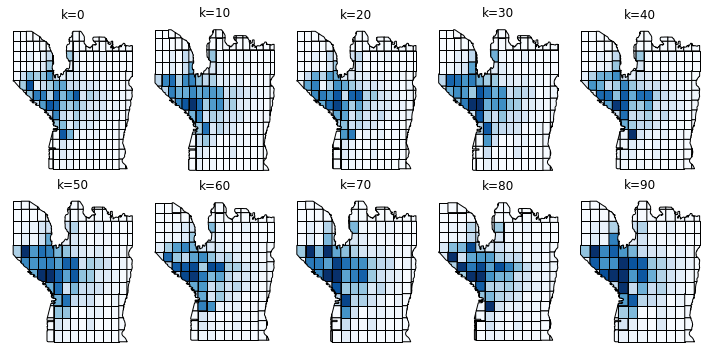

In [2]:
gdf_census = gpd.read_file("sea_loc_data/2020_census_tracts_seattle.geojson")
gdf_census['BASENAME'] = gdf_census['BASENAME'].astype(float)

fig, axs = plt.subplots(2, 5, figsize=(10, 5))  # 1 row, 3 columns
gdfs = [None for _ in range(10)]
for i,partition_index in enumerate(range(0,100,10)):
    ax1 = int(i/5)
    ax2 = i%5
    gdfs[i] = pd.read_csv(f'sea_pred_results/mixed_effects_results_{partition_index}/mixed_effects_8-830_{partition_index}.csv')
    gdfs[i]['geometry'] = gdfs[i]['geometry'].apply(wkt.loads)
    gdfs[i] = gpd.GeoDataFrame(gdfs[i], crs='epsg:4326')
    geometry_mapping = gdf_census.set_index('BASENAME')['geometry'].to_dict()
    gdfs[i].plot(column='book_num_train', ax=axs[ax1,ax2], legend=False, legend_kwds={"shrink":.9}, \
                 cmap='Blues', edgecolor='black', linewidth=1, vmin=0,vmax=100)

titles = ['k=0','k=10','k=20','k=30','k=40','k=50','k=60','k=70','k=80','k=90']

for i in range(2):
    for j in range(5):
        axs[i,j].set_title(titles[i*5+j])  # Set specific titles for the 6th, 7th, and 8th subplots
        axs[i,j].set_axis_off()

plt.tight_layout()
# Show plot
plt.show()

### Plot Weighted Frequencies of Block-Level Relative Errors in Testing Data

In [3]:
filter_column = 'book_num_test'

gdfs = [None for _ in range(12)]
all_data = [[] for _ in range(12)]
weight_list = []

for i in range(12):
    if i < 10:
        for partition_index in range(100):
            if i==0:
                gdf_mixed_effects = pd.read_csv(f'sea_pred_results/mixed_effects_results_0/mixed_effects_8-830_{partition_index}.csv')
            else:
                gdf_mixed_effects = pd.read_csv(f'sea_pred_results/mixed_effects_results_{i}0/mixed_effects_8-830_{partition_index}.csv')
            
            gdf_mixed_effects['geometry'] = gdf_mixed_effects['geometry'].apply(wkt.loads)
            gdf_mixed_effects = gpd.GeoDataFrame(gdf_mixed_effects, crs='epsg:4326')
            gdf_mixed_effects['test_error'] = (gdf_mixed_effects['book_num_pred']-gdf_mixed_effects['book_num_test'])/ \
                                               gdf_mixed_effects['book_num_test']
            gdf_mixed_effects['train_error'] = (gdf_mixed_effects['book_num_train_pred']-gdf_mixed_effects['book_num_train'])/ \
                                                gdf_mixed_effects['book_num_train']
            filtered_gdf_mixed_effects = gdf_mixed_effects[gdf_mixed_effects[filter_column] >= 3]
            all_data[i].extend(filtered_gdf_mixed_effects['test_error'].dropna().tolist())
            if i==0:
                weight_list.extend(filtered_gdf_mixed_effects['book_num_test'].dropna().tolist())
    elif i == 10:
        for partition_index in range(100):
            gdf_disc = pd.read_csv(f'sea_pred_results/discovery_results/disc_batch_8-830_{partition_index}.csv')
            gdf_disc['geometry'] = gdf_disc['geometry'].apply(wkt.loads)
            gdf_disc = gpd.GeoDataFrame(gdf_disc, crs='epsg:4326')
            gdf_disc['test_error'] = (gdf_disc['book_num_pred']-gdf_disc['book_num_test'])/gdf_disc['book_num_test']
            gdf_disc['train_error'] = (gdf_disc['book_num_train_pred']-gdf_disc['book_num_train'])/gdf_disc['book_num_train']
            filtered_gdf_disc = gdf_disc[gdf_disc[filter_column] >= 3]
            all_data[i].extend(filtered_gdf_disc['test_error'].dropna().tolist())

    else:
        for partition_index in range(100):
            gdf_allin = pd.read_csv(f'sea_pred_results/allin_results/allin_8-830_{partition_index}.csv')
            gdf_allin['geometry'] = gdf_allin['geometry'].apply(wkt.loads)
            gdf_allin = gpd.GeoDataFrame(gdf_allin, crs='epsg:4326')
            gdf_allin['test_error'] = (gdf_allin['book_num_pred']-gdf_allin['book_num_test'])/gdf_allin['book_num_test']
            gdf_allin['train_error'] = (gdf_allin['book_num_train_pred']-gdf_allin['book_num_train'])/gdf_allin['book_num_train']
            filtered_gdf_allin = gdf_allin[gdf_allin[filter_column] >= 3]
            all_data[i].extend(filtered_gdf_allin['test_error'].dropna().tolist())

total_bookings = np.sum(filtered_gdf_allin['book_num_test'])
abs_list_of_lists = [[abs(item) for item in sublist] for sublist in all_data]

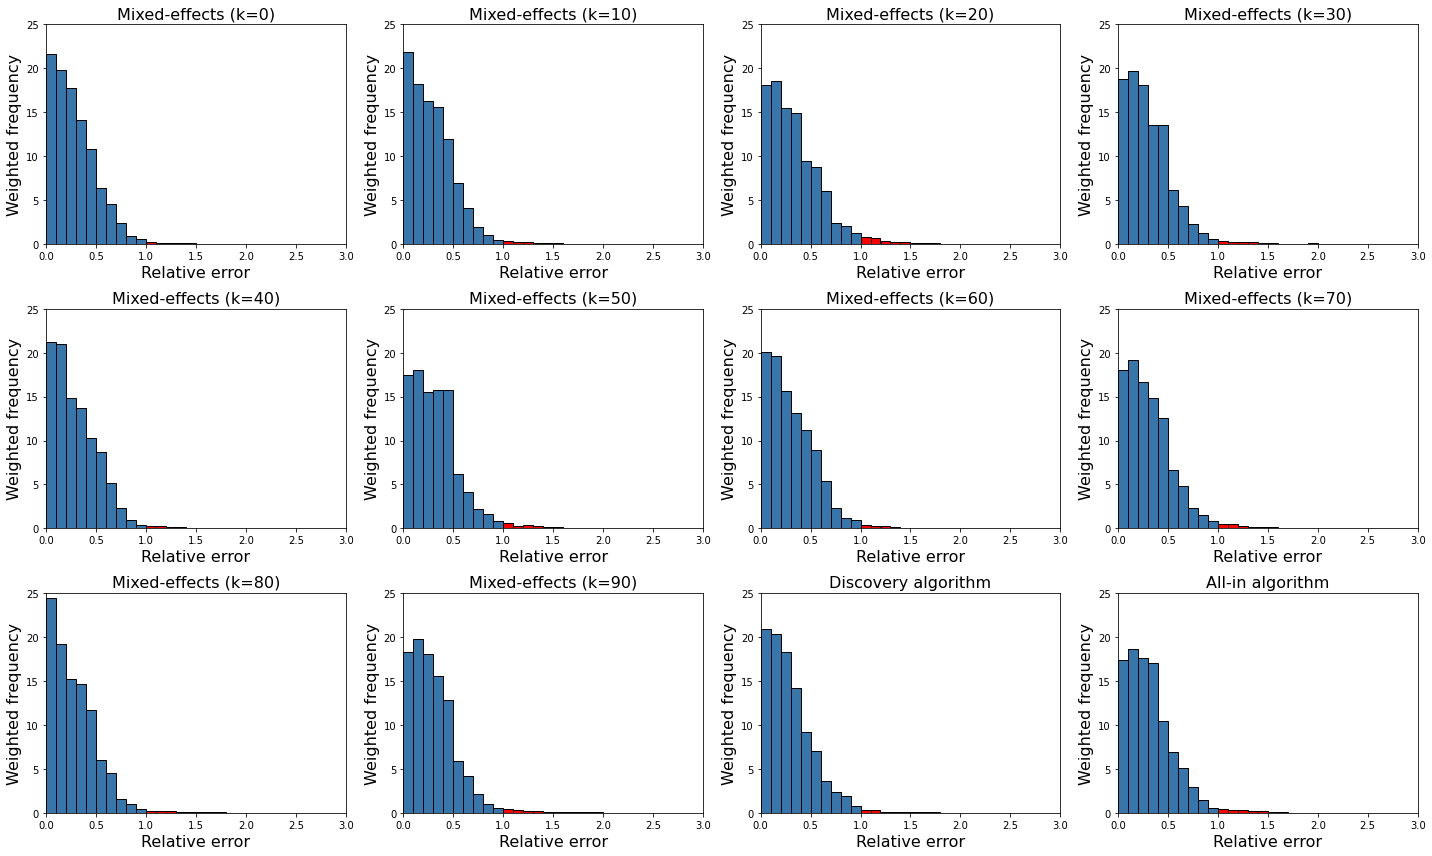

In [4]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust the space between subplots

# Titles for each subplot
titles = ['Mixed-effects (k=0)','Mixed-effects (k=10)','Mixed-effects (k=20)',
    'Mixed-effects (k=30)', 'Mixed-effects (k=40)', 'Mixed-effects (k=50)', 'Mixed-effects (k=60)',
    'Mixed-effects (k=70)','Mixed-effects (k=80)','Mixed-effects (k=90)', 
    'Discovery algorithm', 'All-in algorithm'
]

# Plot histograms
for i in range(3):
    for j in range(4):

        index = 4 * i + j
        n, bins, patches = axs[i, j].hist(abs_list_of_lists[index],weights = np.array(weight_list)/total_bookings,bins=np.arange(-1, 3, 0.1), edgecolor='black')
        
        # Change the color of bars
        for patch, bin_left in zip(patches, bins[:-1]):
            if bin_left >= 0.9:
                patch.set_facecolor('red')
            else:
                patch.set_facecolor('#3776ab')
        
        axs[i, j].set_xlim([0, 3])  # Set x-axis range
        axs[i, j].set_ylim([0, 25])  # Set y-axis range
        axs[i, j].set_title(titles[index],fontsize=16)  # Set specific titles for the 6th, 7th, and 8th subplots
        axs[i, j].set_xlabel('Relative error',fontsize=16)  # Add x-axis label
        axs[i, j].set_ylabel('Weighted frequency',fontsize=16)  # Add y-axis label
            
plt.tight_layout()
plt.show()